In [1]:
# Importing the necessary modules
import numpy as np
import matplotlib.pyplot as plt

In my neural network, I plan to have input and output layer each with 1 node where there is no activation function for the output layer. Also, each hidden layer will have the same number of nodes and activation function.

## Defining Input Variables

In [2]:
# Variables necessary for input data
damping_coefficient = 50    # maximum allowed is 54
error =0
initial_displacement = 1
number_points = 50

# Variables to define the neural network
learning_rate = 0.8
number_layers = 1
number_nodes = 1
num_iterations = 20000
pin = 2     # 1->Sigmoid, 2->tanh, 3->ReLU, 4->LeakyReLU

## Creating Input Data

In [3]:
def X_data():
    # Defining some varibales
    natural_w = np.sqrt(12/63)
    damping_ratio = damping_coefficient/(2*63*natural_w)
    damping_w = natural_w*(np.sqrt(1-(damping_ratio**2)))
    phi = np.arctan((np.sqrt(1-(damping_ratio**2))/damping_ratio))
    amplitude = initial_displacement*natural_w/damping_w

    X = np.linspace(0, 2*np.pi/damping_w, num= number_points, endpoint=True)
    X = X.reshape(number_points, 1)
    y = np.array((amplitude*np.exp(-damping_ratio*natural_w*X))*np.sin(damping_w*X+phi))
    
    y = y.T
    # Creating noise in the input
    err = (-error+2*error*np.random.random(number_points))/100
    y = y + y*err

    mean = np.mean(X)
    std = np.std(X)
    X = (X-mean)/std
    
    return X.T, y, mean, std

## Defining Activation Functions


In [4]:
def activation_function(x):
    # Defining sigmoid function
    if pin == 1:
        return 1/(1+np.exp(-x))
    
    # Defining tanh function
    if pin == 2:
        return np.tanh(x)
    
    # Defining ReLU
    if pin == 3:
        return np.maximum(x, 0)
    
    # Defining Leaky ReLU
    if pin == 4:
        return np.maximum(0.01*x, x)
    
def activation_derivative(x):
    # Defining sigmoid function
    if pin == 1:
        return activation_function(x)*(1-activation_function(x))
    
    # Defining tanh function
    if pin == 2:
        return 1-np.square(activation_function(x))
    
    # Defining ReLU
    if pin == 3:
        return np.where(x>0, 1.0, 0)
    
    # Defining Leaky ReLU
    if pin == 4:
        return np.where(x>0, 1, 0.01)

## Forward Propagation


In [5]:
def initialise_parameters():
    parameters = {}

    # From input layer to first hidden layer
    parameters['W0'] = np.ones([number_nodes, 1])
    parameters['b0'] = np.ones([number_nodes, 1])

    # Between hidden layers
    for i in range(1, number_layers):
        parameters['W'+str(i)] = np.ones([number_nodes, number_nodes])
        parameters['b'+str(i)] = np.ones([number_nodes, 1])

    # From last hidden layer to the output layer
    parameters['W'+str(number_layers)] = np.ones([1, number_nodes])
    parameters['b'+str(number_layers)] = np.ones([1,1])
    return parameters

In [6]:
def forward_propagation(X, parameters):
    dict_Z = {}
    dict_A = {}
    dict_A['A0'] = X
    
    # Doing for the first iteration
    dict_Z['Z1'] = (np.dot(parameters['W0'], X) + parameters['b0'])
    dict_A['A1'] = activation_function(dict_Z['Z1'])

    for i in range(1, number_layers):
        A_prev = dict_A['A'+str(i)]
        dict_Z['Z'+str(i+1)] = (np.dot(parameters['W'+str(i)], A_prev) + parameters['b'+str(i)])
        dict_A['A'+str(i+1)] = activation_function(dict_Z['Z'+str(i+1)])

    # Doing for the last set of weights
    dict_Z['Z'+str(number_layers+1)] = (np.dot(parameters['W'+str(number_layers)], dict_A['A'+str(number_layers)]) + parameters['b'+str(number_layers)])
    dict_A['A'+str(number_layers+1)] = dict_Z['Z'+str(number_layers+1)]

    return dict_Z, dict_A

In [7]:
def MSE(Y, dict_A):
    AL = dict_A['A'+str(number_layers+1)]
    m = Y.shape[1]

    mse = 1/(2*m)*np.sum(np.square(AL-Y))
    return mse

## Back Propagation


In [8]:
def backward_propagation(Y, dict_A, dict_Z, parameters):
    gradient = {}
    delta = {}
    m = Y.shape[1]

    delta[str(number_layers+1)] = (dict_A['A'+str(number_layers+1)]-Y)*activation_derivative(dict_Z['Z'+str(number_layers+1)])

    gradient['dW'+str(number_layers)] = delta[str(number_layers+1)].dot(dict_A['A'+str(number_layers)].T)/m
    gradient['dB'+str(number_layers)] = np.sum(delta[str(number_layers+1)], axis =1, keepdims = True)/m

    for i in reversed(range(1, number_layers+1)):
        # print(np.shape(delta[str(i+1)]))
        delta[str(i)] = (parameters['W'+str(i)].T).dot(delta[str(i+1)])*activation_derivative(dict_Z['Z'+str(i)])

        gradient['dW'+str(i-1)] = delta[str(i)].dot(dict_A['A'+str(i-1)].T)/m
        gradient['dB'+str(i-1)] = np.sum(delta[str(i)], axis = 1, keepdims= True)/m
    
    return gradient

In [9]:
def update_parameters(parameters, gradient):
    for i in range(number_layers+1):
        parameters['W'+str(i)] -= learning_rate*gradient['dW'+str(i)]
        parameters['b'+str(i)] = parameters['b'+str(i)] - learning_rate*gradient['dB'+str(i)]
    return parameters

## Main Function


In [10]:
X, y, mean, std = X_data()
parameters = initialise_parameters()

for i in range(num_iterations):
    dict_Z, dict_A = forward_propagation(X, parameters)
    if ((i%1000) == 0):
        print(MSE(y, dict_A))
    gradient = backward_propagation(y, dict_A, dict_Z, parameters)
    parameters = update_parameters(parameters, gradient)

AL = (dict_A['A'+str(number_layers+1)])[0]
Y = y[0]
x = X[0]

1.2511424442904817
0.00037393629391985596
0.00015055960046487442
0.00012066671032226253
9.475082022355905e-05
7.190054456563018e-05
5.5330275645473034e-05
4.403442274437034e-05
3.624770602171485e-05
3.074489585257932e-05
2.677343397982417e-05
2.385892636905977e-05
2.1690130442638042e-05
2.00566226593893e-05
1.8812933206876526e-05
1.785668819550122e-05
1.711475568577416e-05
1.653421255493531e-05
1.6076321075035628e-05
1.5712436293066214e-05


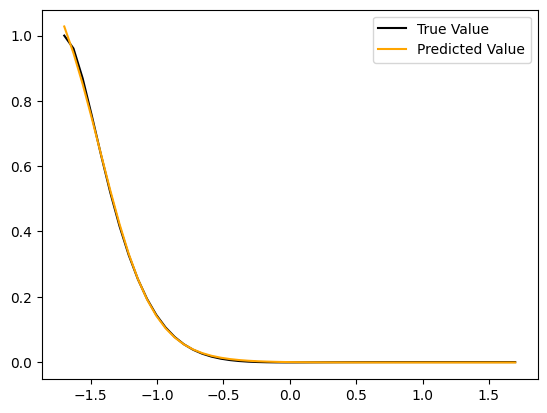

In [13]:
# Plotting the above findings
plt.plot(x, Y, color='black', label='True Value')
plt.plot(x, AL, color='orange', label='Predicted Value')

plt.legend()

plt.show()
